Note: Differential Evolution is a stochastic optimization procedure. I typically run each demo result a few times to make sure it's reasonably stable, but if you run it yourself and get something wildly different, simply rerunning the fit is an easy solution.

In [1]:
# Imports and display settings:
import pyvan
import numpy as np
import matplotlib.pyplot as plt
import pkg_resources

# Turn on interactive plotting
%matplotlib notebook

# Widen notebook space to 95% of window size and increase font sizes
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))
display

<function IPython.core.display.display>

Here we'll work through how to define templates of your own. 

For this example, we'll imagine we're trying to study a type of star whose light-curves are well described by two sinusoids in magnitude-space, but are concerned about contamination from some group described by a single sine wave--- henceforth "two-sine" and "sine" respectively. To identify a safe population of two-sines we can use PyVAN to look for targets much better described by a two sinusoid fit than by a single sine. 

To fit a new template in PyVAN, we need to define a template function. This function should take an array of times and explicitly defined template parameters and return an array of magnitudes. We also need to define the boundaries for this template. These boundaries can be:
- a callable function which takes "data" as it's argument (where data is a light-curve array as setup in the Example 1 notebook), and returns tuples/arrays giving a min and max boundary for each template parameter.
- a list of hard parameter bound tuples/arrays (if you don't want to inform the boundaries based on evidence in your light-curve)

We'll define our template and template bound functions as follows:

In [2]:
def sine_fn(t, m0, t0, dt, dm):
    """
    m0 is the base magnitude for the target. t0 is the offset of the beginning of the period from the start of the data in days. dt is the period in days. dm is the amplitude of the features.
    """
    T = (t-t0)/dt
    return m0 + dm*np.sin(T*2*np.pi)

def sine_bounds(data):
    time, mag, magErr = data['mjd'], data['mag'], data['magErr']
    m0_err = pyvan.med_err(mag)
    m0 = np.median(mag) + m0_err*np.array([-3, 3]) 
    dm = np.array([0.1, 2])
    dt = np.array([0.05, 1])
    t0 = np.min(time) + np.array([0, dt[1]])
    return m0, t0, dt, dm

def two_sine_fn(t, m0, t01, dt1, dm1, t02, dt2, dm2):
    """
    Arguments as for sine_fn, but with two of each (except m0)
    """
    model = np.zeros((3, len(t)))
    model[-1] = np.repeat(m0, len(t))
    model[0] = sine_fn(t, 0, t01, dt1, dm1)
    model[1] = sine_fn(t, 0, t02, dt2, dm2)
    model = np.sum(model, axis = 0)
    return model
    
def two_sine_bounds(data):
    time, mag, magErr = data['mjd'], data['mag'], data['magErr']
    m0_err = pyvan.med_err(mag)
    m0 = np.median(mag) + m0_err*np.array([-3, 3])
    dm = np.array([0.1, 1])
    dt = np.array([0.05, 1])
    t0 = np.min(time) + np.array([0, dt[1]])
    return  m0, t0, dt, dm, t0, dt, dm

Now we want to prepare our new templates in dictionaries to pass to PyVAN's functions. These dictionaries require entries as follows: 
- "fn" - the template function
- "bounds" - templates boundaries/boundary functions
- "args" - a list of the strings naming the parameters for your template function
- "name" - a string to identify the template in the returned fit dictionary

Note: make sure the arguments in "args", the returned parameter bounds from the "bounds" function, and the arguments in "fn" are in the same order.

In [3]:
sine_dict = {'fn': sine_fn, 'bounds': sine_bounds, 'args': ['m0', 't0', 'dt', 'dm'], 'name': 'sine'}
two_sine_dict = {'fn': two_sine_fn, 'bounds': two_sine_bounds, 'args': ['m0', 't01', 'dt1', 'dm1', 't02', 'dt2', 'dm2'], 'name': 'two_sine'}

It's probably not a bad idea to save these dictionaries with pickle or to write them to a python program to import later (so you can see where you messed up defining these later, or for plotting them!). A reminder regarding pickle from the last example notebook:

    import pickle
    pickle.dump(sine_dict, open('/my_dir/sine_template_dict.p','wb'))
    
Which can be loaded later with:

    import pickle
    fit_dict = pickle.load(open('/my_dir/sine_template_dict.p', 'rb'))
    
    
Next we'll load up and prepare a few example light-curves (which I created by randomly drawing parameters and inducing ground-quality noise/sampling with the templates above):

I've created a "high quality" test light-curve for each of these identities, with parameters drawn from within our expected bounds, and also generated a ground-based quality light-curve for us to fit. We'll load the first one:

In [4]:
ex_dir = pkg_resources.resource_filename('pyvan', 'example_data/')

donor_lc_3 = np.genfromtxt(ex_dir+'donor_3.dat', names=True)
lc_3 = np.genfromtxt(ex_dir+'sim_3.dat', names=True) 

Fitting it with our two templates, and printing the difference of log-likelihoods:

In [5]:
tar_fit3 = pyvan.fit_target(lc_3, filt=None, threshold=None, templates = [sine_dict, two_sine_dict], flare_cands=None)
print tar_fit3['rel_fit']

{'sine-two_sine': -51.00617732491642}


The result indicates a strong preference for the two-sine model over the sine model.

Let's see how we did by plotting our fits with the data and the donor data:

<IPython.core.display.Javascript object>


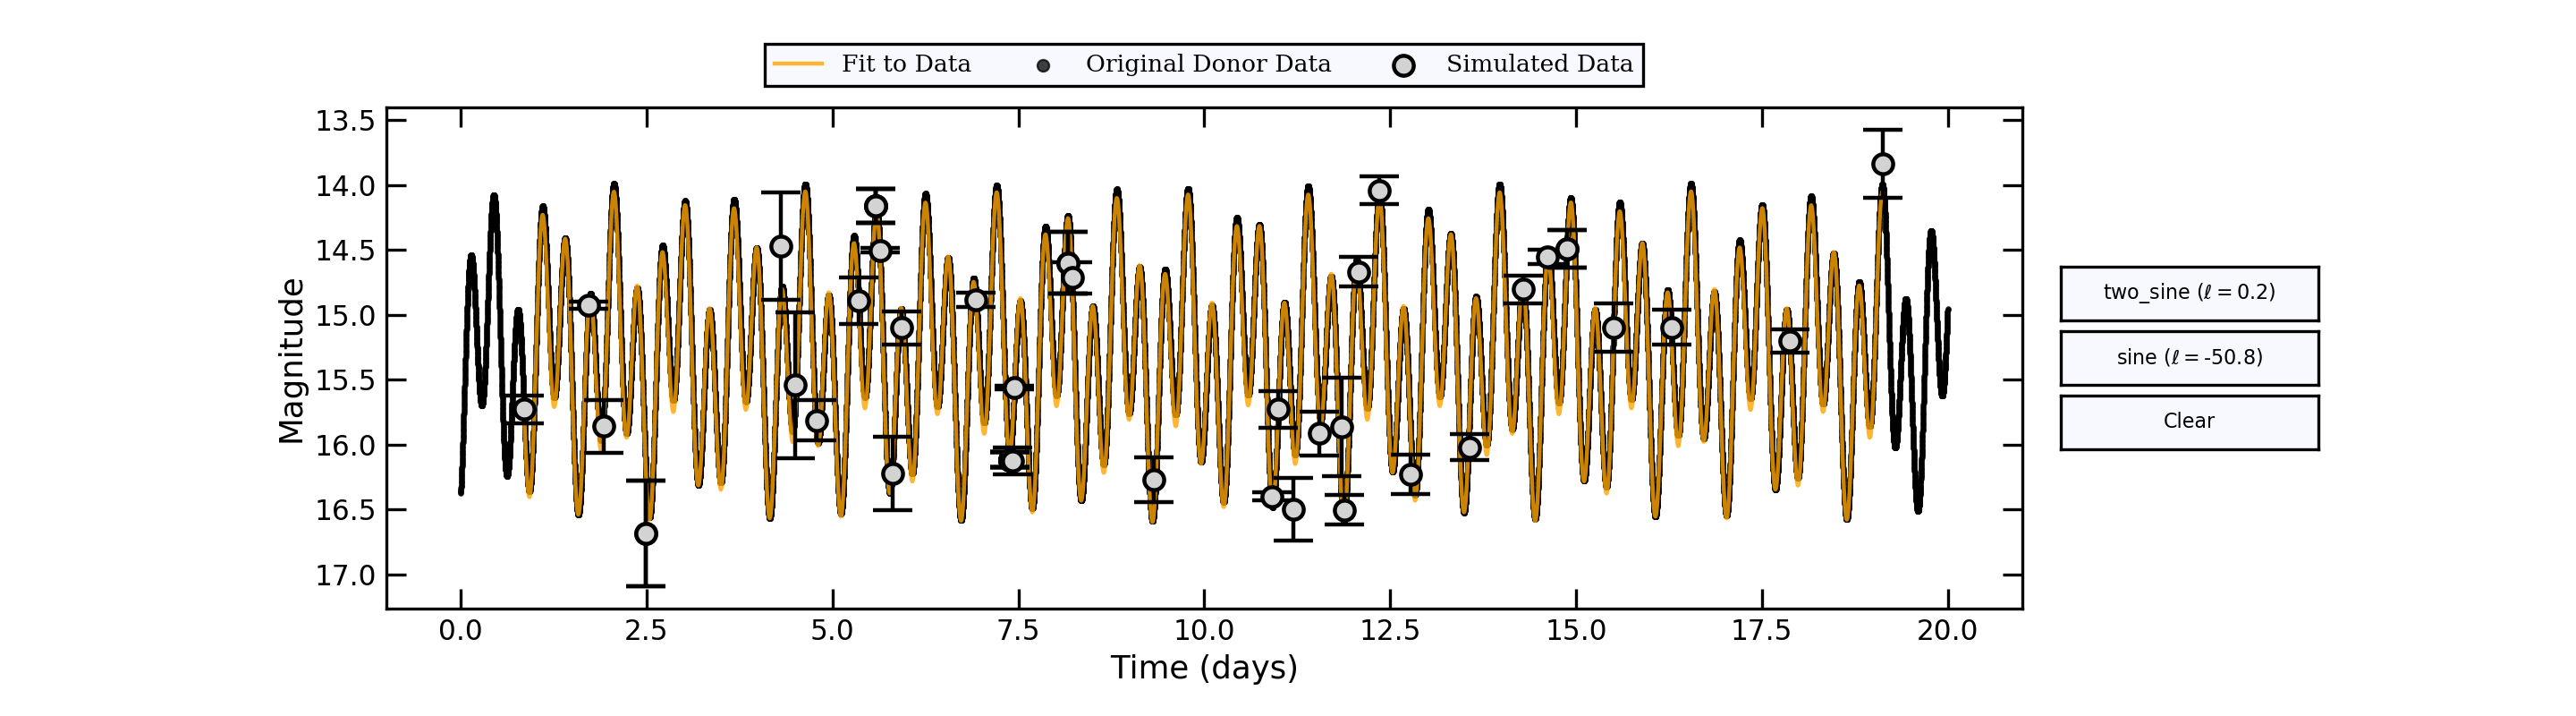

In [6]:
pyvan.plot_all_fits(tar_fit3, templates=['sine', 'two_sine'], donor_lightcurve=donor_lc_3)

Sure enough, this was the "two-sine" target. We recover a model pretty close to the true shape (though in cases of lower amplitude or more sparse sampling we probably wouldn't do quite this well).

Now onto the second target. By elimination, we can correctly assume that this light-curve was generated using our template for the single sine target. Loading the "data":

In [7]:
donor_lc_4 = np.genfromtxt(ex_dir+'donor_4.dat', names=True)
lc_4 = np.genfromtxt(ex_dir+'sim_4.dat', names=True)

In [8]:
tar_fit4 = pyvan.fit_target(lc_4, filt=None, threshold=None, templates = [sine_dict, two_sine_dict], flare_cands=None)
print tar_fit4['rel_fit']

{'sine-two_sine': -0.04877489856617179}


<IPython.core.display.Javascript object>


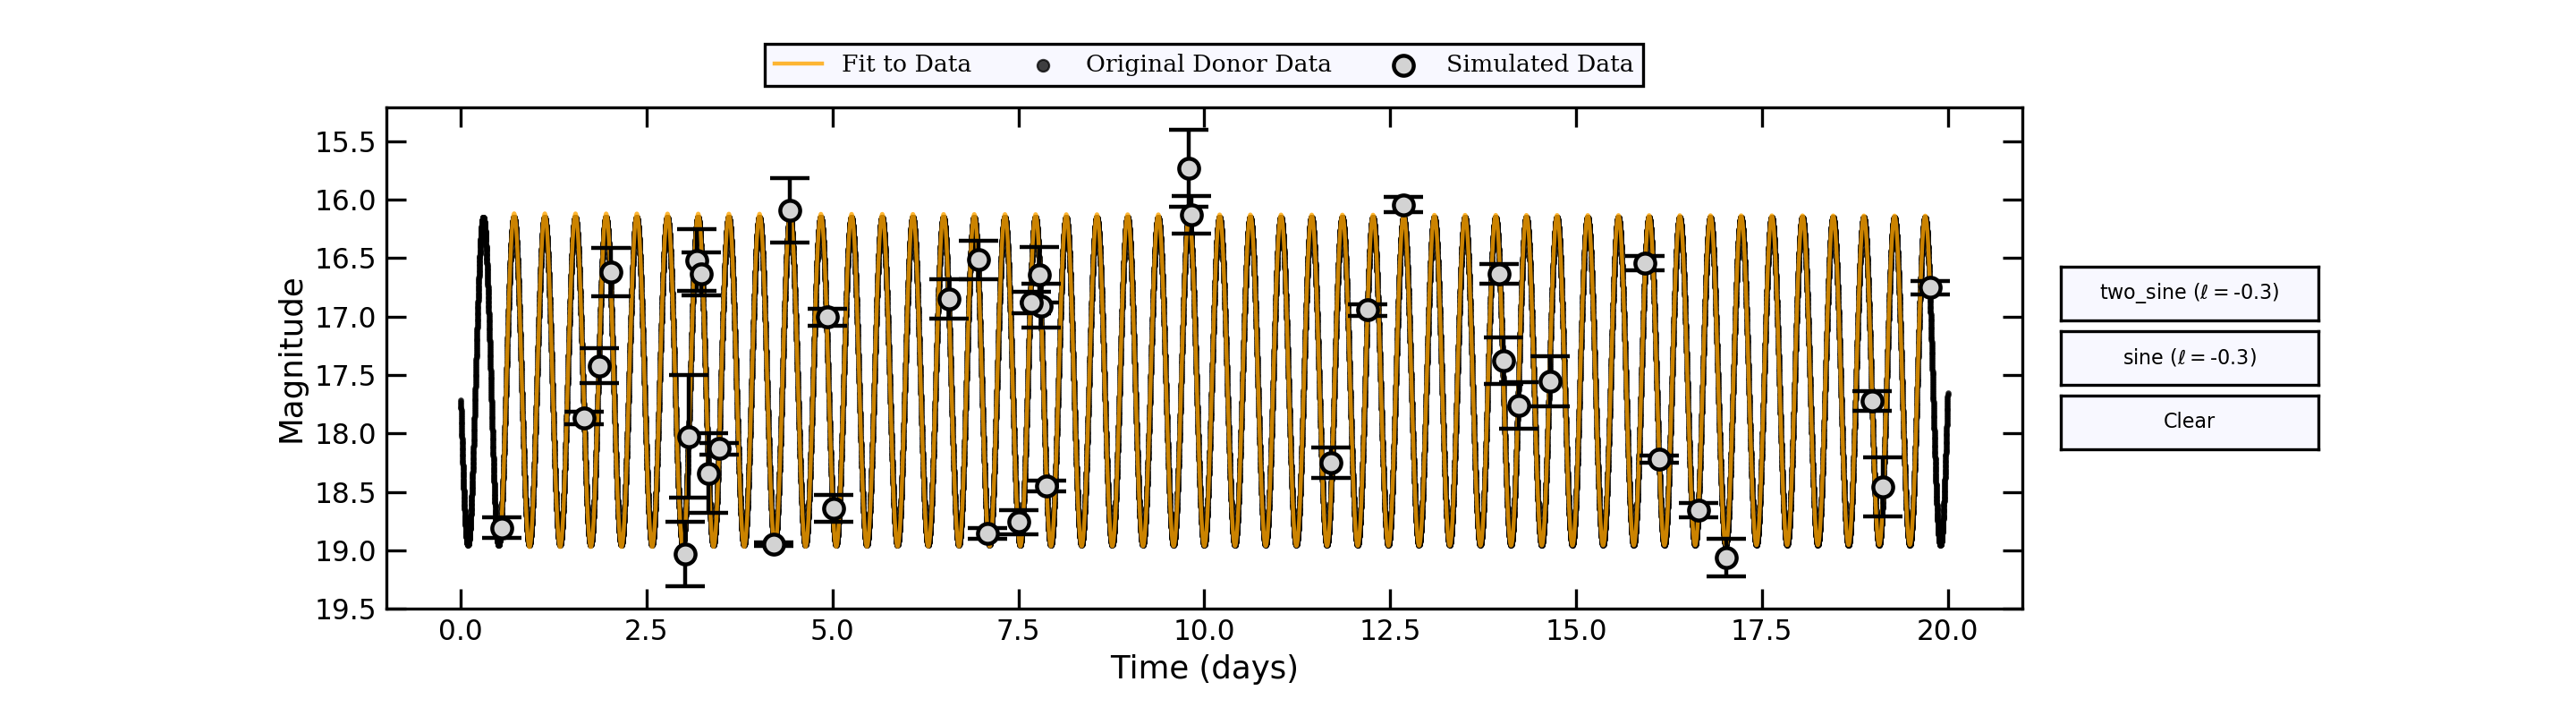

In [9]:
pyvan.plot_all_fits(tar_fit4, templates=['sine', 'two_sine'], donor_lightcurve=donor_lc_4)

For this target, we find a two-sine model that is very nearly identical to the sine model, both of which describe the original light-curve shape well. Below, we take a closer look at this result by first plotting the two curves making up the two sine model, and then plotting the difference of the two models.

<IPython.core.display.Javascript object>


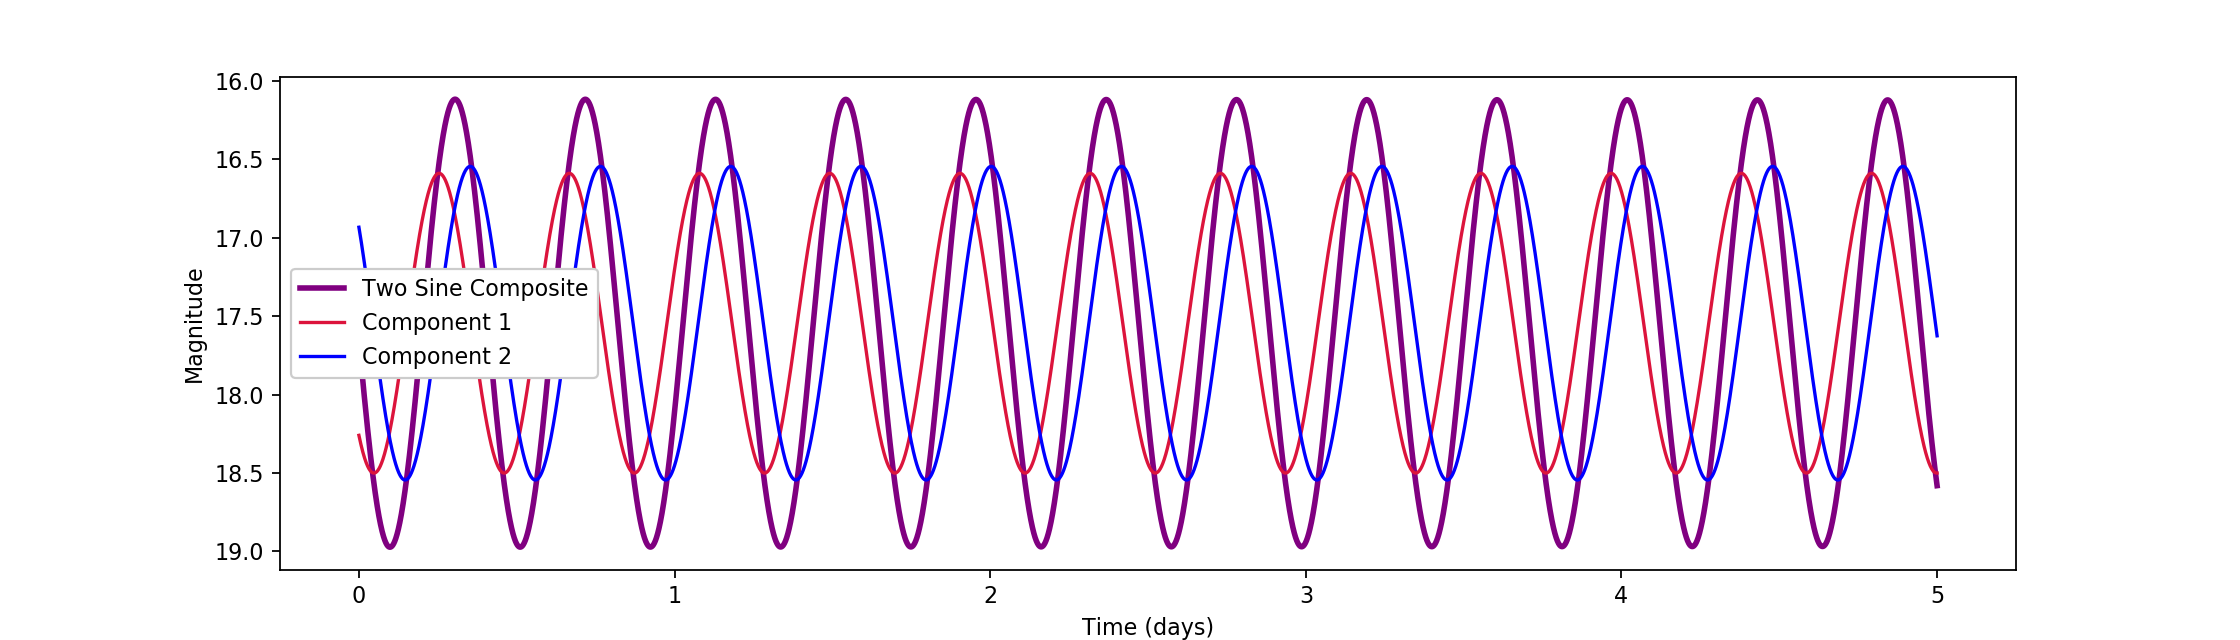

In [10]:
params = tar_fit4['two_sine']['params']

plt.figure(figsize=(14,4))

time = np.linspace(0,5,10000)
plt.plot(time, two_sine_fn(time,*params), label='Two Sine Composite', c='purple', lw=2.5)
plt.plot(time, sine_fn(time, params[0], *params[1:4]), c='crimson', label='Component 1')
plt.plot(time, sine_fn(time, params[0], *params[4:]), c='blue', label='Component 2')
plt.ylim(plt.ylim()[::-1])

plt.legend(framealpha=1.)
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')
plt.show()

<IPython.core.display.Javascript object>


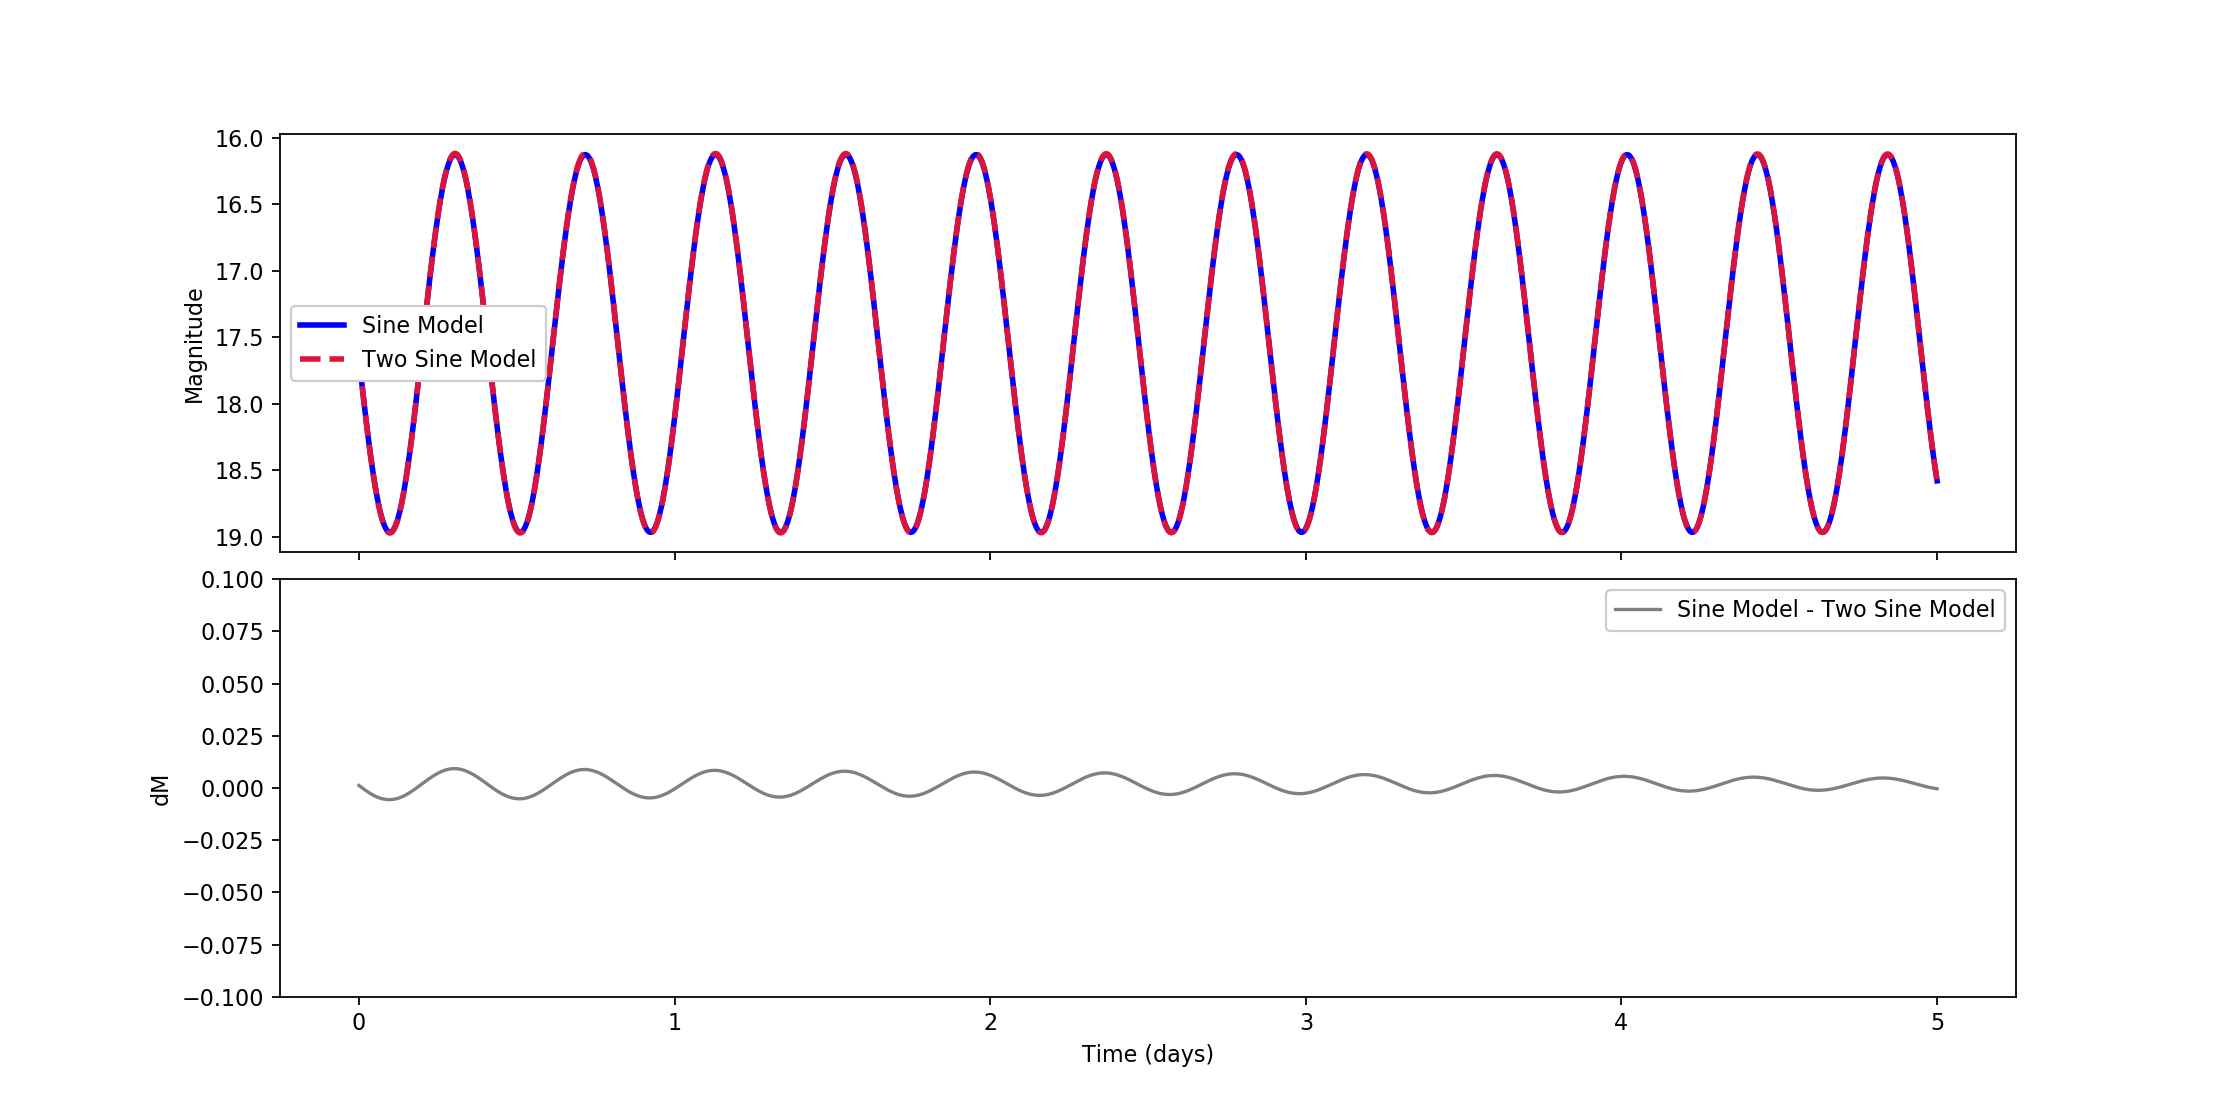

In [11]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,7), sharex=True)
fig.subplots_adjust(hspace=0.065)

time = np.linspace(0,5,10000)
sine_model = sine_fn(time, *tar_fit4['sine']['params'])
two_sine_model = two_sine_fn(time, *tar_fit4['two_sine']['params'])

ax1.plot(time, sine_model, label='Sine Model', c='blue', lw=2.5)
ax1.plot(time, two_sine_model, label='Two Sine Model', ls='dashed', c='crimson', lw=2.5)
ax1.legend(framealpha=1.)
ax1.set_ylim(ax1.set_ylim()[::-1])
ax1.set_ylabel('Magnitude')

ax2.plot(time, sine_model - two_sine_model, c='gray', label='Sine Model - Two Sine Model')
ax2.legend(framealpha=1.)
ax2.set_ylabel('dM')
ax2.set_ylim(-0.1, 0.1)
ax2.set_xlabel('Time (days)')
plt.show()

Since the two-sine model is free to choose two individual sine functions whose composite is effectively indistinguishable from a single sine function, this test does not invert well for these types of targets. i.e. it would be extremely difficult to isolate a population of "Sine" stars unlikely to contain contamination by "Two-Sine" stars. 

If we were to simulate and fit a large sample of light-curves for each of these archetypes and then plot a histogram of each group's 'sine-two_sine' difference of log-likelihoods, we might expect:

- For the sine sample: A sharp gaussian distribution near zero. We would likely see a slight skew in the "two-sine" direction since the two-sine model allows an additional degree of freedom that could result in "Sine" light-curves that are actually slightly better fit by the two component model due to noise.


- For the two-sine sample: A left skewed gaussian distribution, where light-curves with poorly constrained morphologies (as a result of small amplitude variability or poor/noisy sampling) remain near zero, and less ambiguous light-curves are pulled further left.

Based on this, we might then decide some threshold value of the difference of our log-likelihoods. This threshold should be chosen to eliminate as many contaminating "Sine" stars as possible, while leaving a sample of "Two-Sine" candidates of a size that can be feasibly visually inspected. Visual inspection helps insure that the metrics are working properly, and that no other contaminant populations which are poorly separated by these fits remain.